In [3]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

In [5]:
data_path = os.path.expanduser('Data/Data1.csv')
df = pd.read_csv(data_path, comment='#')
df.rename(columns={
    'Timestamp': 'timestamp',
    'Royal Canin Lowfat Can (13.6oz)': 'can',
    'Sweet Potato (11.5oz)': 'sweet',
    'Golden Potato (5.2oz)': 'golden',
    'Outcome': 'outcome',
    'Were We Sleeping / Jake Was Alone Just Before': 'alone',
    'Was it an Accident?': 'accident',
    'Notes': 'notes',
    'Poop Event': 'poop',
    'Feed Event': 'feed'
}, inplace=True)
df.head()

,timestamp,can,sweet,golden,outcome,alone,accident,notes,poop,feed
0,1545929878,2.0,1.0,1.0,NaN,NaN,NaN,NaN,False,True
1,1545930646,NaN,NaN,NaN,2.0,NaN,NaN,Outside,True,False
2,1545943282,2.0,1.0,1.0,NaN,NaN,NaN,NaN,False,True
3,1545948608,NaN,NaN,NaN,2.0,NaN,NaN,Outside,True,False
4,1545948875,NaN,NaN,NaN,NaN,NaN,NaN,Jake got 2 gabapentin at lunch and 2 at 2pm. O...,False,True


In [6]:
# This was done once on the original dataset. No longer necessary
# def to_timestamp(t):
#     dt = datetime.strptime(t, '%m/%d/%Y %H:%M:%S')
#     return dt.strftime('%s')
# df.timestamp = [to_timestamp(t) for t in df.timestamp.values]

# set(df.outcome)
# renames = {'Big One': 3, 'Regular': 2, 'No Poop': 0}
# for k, v in renames.items():
#     df.loc[df.outcome == k, 'outcome'] = v


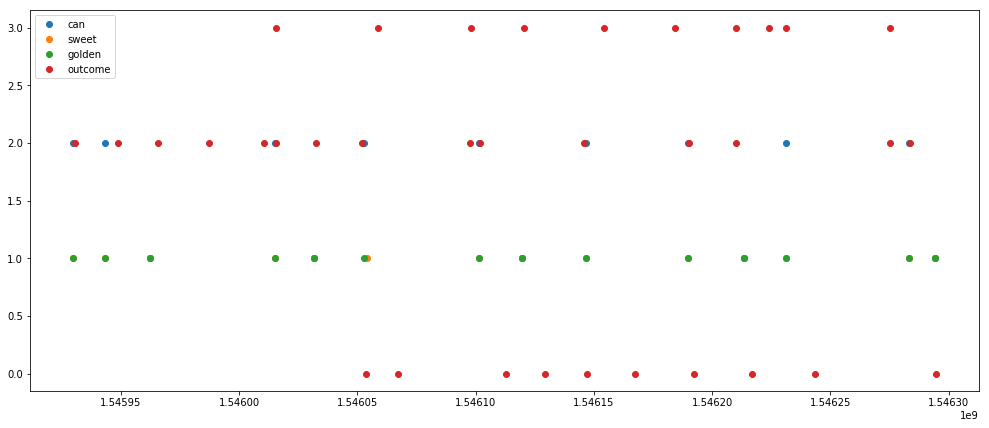

In [7]:
plt.figure(figsize=(17, 7))
plt.plot(df.timestamp, df.can, 'o', alpha=1, label='can')
plt.plot(df.timestamp, df.sweet, 'o', alpha=1, label='sweet')
plt.plot(df.timestamp, df.golden, 'o', alpha=1, label='golden')
plt.plot(df.timestamp, df.outcome, 'o', alpha=1.0, label='outcome')
plt.legend()
plt.show()


In [8]:
ddf = df.copy()
ddf.loc[df.index, 'poop'] = False
ddf.loc[df.index, 'feed'] = True
ddf.loc[df.outcome >= 0, 'poop'] = True
ddf.loc[df.outcome >= 0, 'feed'] = False
ddf.loc[df.alone == 'Yes', 'alone'] = True
ddf.loc[df.accident == 'Yes', 'accident'] = True
df = ddf

In [9]:
def accumulate_pastdata(df, hours_ago=24, span=3):
    x = 0; y = 0
    df = df.sort_values(by='timestamp')
    for index, row in df.iterrows():
        if not row.poop:
            continue
        dt = datetime.fromtimestamp(row.timestamp)
        df.loc[index, 'hour_of_day'] = dt.hour
        for h in range(span, hours_ago + span, span):
            start = row.timestamp - (h * 3600)
            end = row.timestamp - (h - span) * 3600
            ddf = df[(df.timestamp > start) & (df.timestamp < end)]
            s = ddf.sum()
            start_str = h - span
            end_str = h
            df.loc[index, 'golden_{}_to_{}'.format(start_str, end_str)] = s.golden
            df.loc[index, 'can_{}_to_{}'.format(start_str, end_str)] = s.can
            df.loc[index, 'sweet_{}_to_{}'.format(start_str, end_str)] = s.sweet
            df.loc[index, 'outcome_{}_to_{}'.format(start_str, end_str)] = s.outcome  
    return df
    

ddf = accumulate_pastdata(df.copy())
ddf.head()

,timestamp,can,sweet,golden,outcome,alone,accident,notes,poop,feed,...,sweet_15_to_18,outcome_15_to_18,golden_18_to_21,can_18_to_21,sweet_18_to_21,outcome_18_to_21,golden_21_to_24,can_21_to_24,sweet_21_to_24,outcome_21_to_24
0,1545929878,2.0,1.0,1.0,NaN,NaN,NaN,NaN,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1545930646,NaN,NaN,NaN,2.0,NaN,NaN,Outside,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1545943282,2.0,1.0,1.0,NaN,NaN,NaN,NaN,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1545948608,NaN,NaN,NaN,2.0,NaN,NaN,Outside,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1545948875,NaN,NaN,NaN,NaN,NaN,NaN,Jake got 2 gabapentin at lunch and 2 at 2pm. O...,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ddf.to_csv('Data/Data1.processed.csv')

In [ ]:
plt.figure(figsize=(17, 7))
print(ddf.columns)
pdf = ddf[ddf.poop == True]
plt.plot(pdf.sweet_0_to_3, pdf.outcome)

In [ ]:
#Classifier

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = np.random.random([100,20])
Y = ddf.outcome[ddf.poop].values > 0
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)
scores = cross_val_score(clf, X, Y, cv=10)

scores.mean()

In [14]:
ddf.outcome[ddf.poop].values > 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True, False,  True, False,
        True, False,  True, False,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True, False])